# Import libraries

In [1]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

# Fetch data

In [2]:
Animal_List = ['QP032', 'QP033', 'QP034','QP049', 'QP050', 
               'QP051', 'QP062', 'QP063', 'QP070', 'QP071', 'QP079']

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_cont.pkl")

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_cont = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_cont = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = ut.get_animal_data('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/',
                                             animal, 
                                             'SOUND_CAT_CONT',
                                             'Trial_Summary')
            all_data_cont = pd.concat([all_data_cont, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_cont, f)

# Filter data

In [3]:
data_df = ut.relabel_ELV(all_data_cont) # Re-label appropriately
data_df = ut.remove_blocks(data_df, 'QP032', [17, 18]) # blocks with wrong distribution
data_df = ut.remove_blocks(data_df, 'QP070', [38, 39]) # spout alignment problem
# only keep data where antibias is False or np.nan
data_df = data_df[(data_df.Anti_Bias == False) | (pd.isna(data_df.Anti_Bias))].reset_index(drop=True)
data_df = ut.filter_min_trials(data_df, 100) # Keep at least 100 valid trials per sessions
data_df = ut.threshold_cutoff(data_df, threshold = 0.7) # Only keep sessions where %correct is > threshold

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data_df = ut.filter_lapses(data_df, threshold = 0.75) # Remove sessions with lapse rates > 20%
    
data_df = ut.add_dist_block(data_df) # Track distribution and mouse specific block_nbs
data_df = ut.check_distributions(data_df, n = 1) # Check thal all subjects have been exposed to all distributions
# data_df = make_blocks_equal(data_df) # Check that all subjects have same number of blocks on each distribution (optional) 
data_df = data_df[data_df['Distribution'].notna()].reset_index(drop=True) # Check distributions are valid
# Ensure thal all blocks follow the desired order (e.g.   ['Uniform', 'Asym_right', 'Asym_left']) (optional)
# data_df = sort_consec_dist(data_df, ['Uniform', 'Asym_right', 'Asym_left']) 

# 1. Setup

In [5]:
import numpy.random as npr
import ssm
from ssm.util import find_permutation

npr.seed(0)

# 2. Input Driven Observations

## 2a. Initialize HMM-GMM 

In [6]:
# Set the parameters of the GLM-HMM
num_states = 3       # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

## 2b. Format Data Correctly 

In [6]:
inpts, true_choices, animal_df = ut.format_data_hmmglm(data_df, 'QP032', input_dim = input_dim)

# 3. Fit GLM-HMM to data and retrieve parameters

## 3a. Maximum Likelihood Estimation

In [7]:
N_iters = 1000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

## 3b. Retrieved parameters

In [8]:
color_dict = {0: '#ff7f00', 1: '#4daf4a', 2: '#377eb8'} 


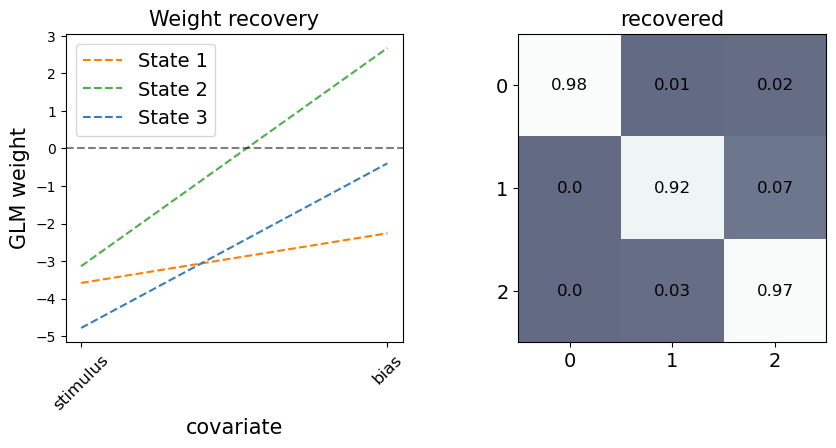

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# First plot
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    ax1.plot(range(input_dim), recovered_weights[k][0], color=color_dict[k],
             lw=1.5,  label='State ' + str(k+1), linestyle='--')
ax1.tick_params(axis='y', labelsize=10)
ax1.set_ylabel("GLM weight", fontsize=15)
ax1.set_xlabel("covariate", fontsize=15)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['stimulus', 'bias'], fontsize=12, rotation=45)
ax1.axhline(y=0, color="k", alpha=0.5, ls="--")
ax1.legend()
ax1.set_title("Weight recovery", fontsize=15)

# Second plot
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
im = ax2.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = ax2.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
ax2.set_xlim(-0.5, num_states - 0.5)
ax2.set_xticks(range(0, num_states))
# ax2.set_xticklabels(('1', '2', '3'), fontsize=10)
ax2.set_yticks(range(0, num_states))
# ax2.set_yticklabels(('1', '2', '3'), fontsize=10)
ax2.set_ylim(num_states - 0.5, -0.5)
ax2.set_title("recovered", fontsize=15)

plt.subplots_adjust(wspace=0.3)
plt.show()

## 3c. Posterior State Probabilities

In [10]:
# Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices, inpts)]

Text(0.5, 0, 'trial #')

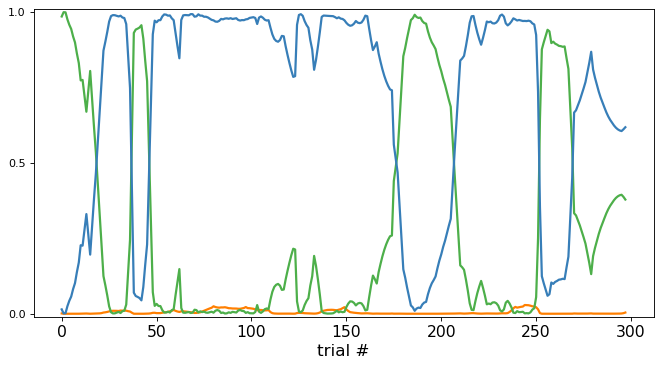

In [11]:
fig = plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
color_dict = {0: '#ff7f00', 1: '#4daf4a', 2: '#377eb8'} 
sess_id = 21 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=color_dict[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)

In [12]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

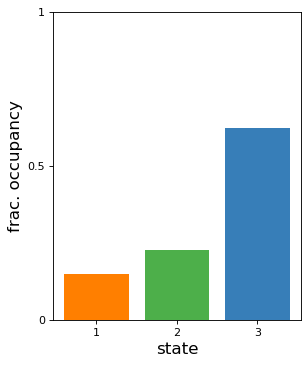

In [13]:
fig = plt.figure(figsize=(4, 5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, 
    color = color_dict[z]
    )
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10) 
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

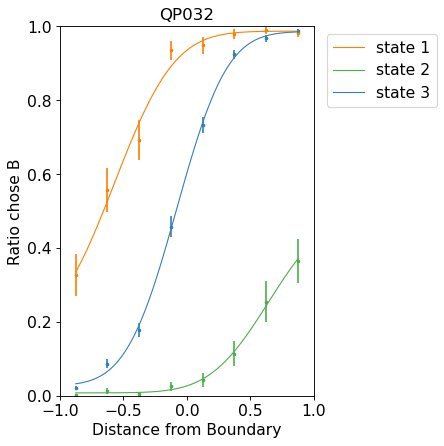

In [14]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for state in range(num_states):
    state_df = animal_df[state_max_posterior == state]
    ut.psycho_plot(state_df, ut.psycho_fit(state_df)[0], 
                   label= 'state ' + str(state+1), 
                   color=color_dict[state], 
                   ax=ax)

plt.title(animal_df.Participant_ID.unique()[0], fontsize=15)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()


# 4. maximum A Priori Estimation (MAP)

In [53]:
# Instantiate GLM-HMM and set prior hyperparameters
prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

In [54]:
# Fit GLM-HMM with MAP estimation:
_ = map_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [55]:
# true_likelihood = true_glmhmm.log_likelihood(true_choices, inputs=inpts)
mle_final_ll = new_glmhmm.log_likelihood(true_choices, inputs=inpts) 
map_final_ll = map_glmhmm.log_likelihood(true_choices, inputs=inpts) 

Text(0, 0.5, 'loglikelihood')

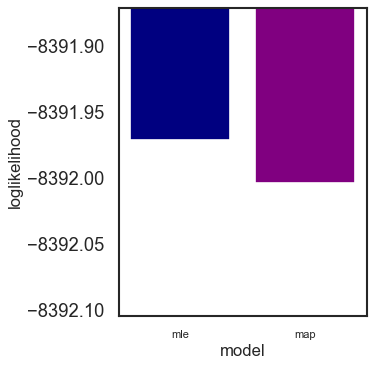

In [56]:
# Plot these values
fig = plt.figure(figsize=(4, 5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_final_ll, map_final_ll]
colors = ['Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.xticks([0, 1], ['mle', 'map'], fontsize = 10)
plt.ylim((np.min(loglikelihood_vals)-0.1, np.max(loglikelihood_vals)+0.1))
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

# 5. Cross Validation

In [57]:
# make animal_data such that it becomes a list of arrays (one array per session) like inpts and true_choices
animal_data = []
for sess in animal_df.block.unique():
    animal_data.append(np.array(animal_df[animal_df.block == sess]))

In [58]:
from sklearn.model_selection import train_test_split
animal_data_train, animal_data_test, choices_train, choices_test, inpts_train, inpts_test = train_test_split(animal_data, 
                                                                                                      true_choices, inpts, 
                                                                                                      test_size=0.3, random_state=42)

In [59]:
# train both mle and map models on training data
mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
mle_ll = mle_glmhmm.fit(choices_train, inputs=inpts_train, method="em", num_iters=N_iters, tolerance=10**-4)

prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
map_ll = map_glmhmm.fit(choices_train, inputs=inpts_train, method="em", num_iters=N_iters, tolerance=10**-4)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [60]:
# Compare likelihood of test_choices for model fit with MLE and MAP:
mle_test_ll = new_glmhmm.log_likelihood(choices_test, inputs=inpts_test) 
map_test_ll = map_glmhmm.log_likelihood(choices_test, inputs=inpts_test) 

Text(0, 0.5, 'loglikelihood')

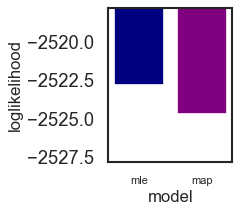

In [64]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_test_ll, map_test_ll]
colors = ['Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((mle_test_ll-5, mle_test_ll+5))
plt.xticks([0, 1], ['mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

I am trying to find the best number of states when fitting an HMM-GLM.
this is how I initialize my HMM-GLM (for example with 2 states):

num_states = 2       # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions
two_state_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
I have inputs X and response y

Normally, this is how I would fit my two_state_glmhmm to all my data:
N_iters = 1000 #
_ = two_state_glmhmm.fit(y_train, inputs=x_train, method="em", num_iters=N_iters, tolerance=10**-4)

And I would test it on held out data like this:

two_state_glmhmm.log_likelihood(y_test, inputs=x_test) 

However, I have no idea how to implement 5-fold cross validation on the training dataset in order to measure the performance pf different number of states (say between 2 and 20) and the test set

#### Compare 2 and 3 state mle HMM-GLM

In [426]:
# initialize model with 2 states
num_states = 2      
two_state_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

In [427]:
# format data for hmm
inpts, choices, animal_df = ut.format_data_hmmglm(data_df, 'QP071', input_dim = input_dim)


In [428]:
animal_data = []
for sess in animal_df.block.unique():
    animal_data.append(np.array(animal_df[animal_df.block == sess]))

In [429]:
animal_data_train, animal_data_test, choices_train, choices_test, inpts_train, inpts_test = train_test_split(animal_data, 
                                                                                                      choices, inpts, 
                                                                                                      test_size=0.3, random_state=42)

In [430]:
# fit two_state_glmhmm to training data
N_iters = 1000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
_ = two_state_glmhmm.fit(choices_train, inputs=inpts_train, method="em", num_iters=N_iters, tolerance=10**-4)

Converged to LP: -4579.6:   7%|▋         | 67/1000 [00:02<00:32, 28.52it/s]


In [431]:
# initialize model with 3 states
num_states = 3
three_state_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs",
                     observation_kwargs=dict(C=num_categories), transitions="standard")

In [432]:
# fit three_state_glmhmm to training data
_ = three_state_glmhmm.fit(choices_train, inputs=inpts_train, method="em", num_iters=N_iters, tolerance=10**-4)

Converged to LP: -4470.8:   7%|▋         | 70/1000 [00:02<00:38, 24.31it/s]


In [433]:
two_state_mle_ll = two_state_glmhmm.log_likelihood(choices_test, inputs=inpts_test) 
three_state_mle_ll = three_state_glmhmm.log_likelihood(choices_test, inputs=inpts_test) 

Text(0, 0.5, 'loglikelihood')

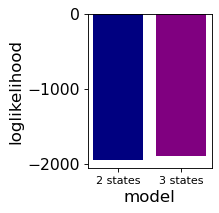

In [434]:
# plot loglikelihoods of test data for 2 and 3 state models
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [two_state_mle_ll, three_state_mle_ll]
colors = ['Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
# plt.ylim((two_state_mle_ll-5, two_state_mle_ll+5))
# plt.ylim(three_state_mle_ll-50, two_state_mle_ll)
# plt.ylim(-2250,-2000)
plt.xticks([0, 1], ['2 states', '3 states'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)


In [435]:
if three_state_mle_ll > two_state_mle_ll:
    print('3 state model is better')
else:
    print('2 state model is better')

3 state model is better


In [436]:
three_state_mle_ll, two_state_mle_ll

(-1897.0154418960446, -1950.0037498181423)

## K-fold cross validation

In [7]:
X, y, animal_df = ut.format_data_hmmglm(data_df, 'QP034', input_dim = input_dim)

In [8]:
animal_data = []
for sess in animal_df.block.unique():
    animal_data.append(np.array(animal_df[animal_df.block == sess]))
    

In [12]:
_, _, y_train, y_test, X_train, X_test = train_test_split(animal_data, y, X, test_size=0.2, random_state=42)

In [46]:
import numpy as np
import ssm
from sklearn.model_selection import KFold

# Define the range of numbers of states to evaluate
n_states_range = range(2, 3)

# Initialize a KFold object to generate the train/validation indices for each fold
n_splits = 5
N_iters = 200
kf = KFold(n_splits)

# Define a dictionary to store the cross-validation results
cv_scores = {}

# Loop over the number of states to evaluate
for n_states in n_states_range:

    # Initialize a new HMM-GLM with the current number of states
    hmm_glm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
    
    # Initialize an array to store the validation log-likelihoods for the current number of states
    val_scores = np.zeros(n_splits)
    
    # Loop over the folds generated by the KFold object
    for i_fold, (train_indices, val_indices) in enumerate(kf.split(X_train)):
        
        # Split the data into training and validation sets for the current fold
        x_train_fold = [X_train[i] for i in train_indices]
        y_train_fold = [y_train[i] for i in train_indices]
        x_val_fold = [X_train[i] for i in val_indices]
        y_val_fold = [y_train[i] for i in val_indices]
        
        # Fit the HMM-GLM to the training data for the current fold
        _ = hmm_glm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=10**-4)
        
        # Evaluate the log-likelihood of the validation data for the current fold
        val_scores[i_fold] = hmm_glm.log_likelihood(y_val_fold, inputs=x_val_fold)
    
    # Compute the mean validation score across all folds for the current number of states
    cv_scores[n_states] = np.mean(val_scores)

# Print the cross-validation scores for each number of states
for n_states in n_states_range:
    print(f"n_states = {n_states}, CV score = {cv_scores[n_states]}")


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

n_states = 2, CV score = -1826.770496557363


# Sanity Checks

- generate fake data using 3 state model
- fit data with range(1,11) num_states
- do this for 100 random initialisations (CIs)

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation
import pandas as pd 
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
npr.seed(0)

In [2]:
# Set the parameters of the GLM-HMM
num_states = 7        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

In [3]:
gen_weights = np.array([
    [[6, 1]],
    [[2, -3]],
    [[2, 3]],
    [[-1, 4]],
    [[5, -2]],
    [[-3, 5]],
    [[4, 0]]
])

trans_mat = np.array([[
    [0.9, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02],
    [0.01, 0.9, 0.01, 0.02, 0.02, 0.02, 0.02],
    [0.01, 0.01, 0.9, 0.02, 0.02, 0.02, 0.02],
    [0.02, 0.02, 0.02, 0.9, 0.01, 0.01, 0.02],
    [0.02, 0.02, 0.02, 0.01, 0.9, 0.01, 0.02],
    [0.02, 0.02, 0.02, 0.01, 0.01, 0.9, 0.02],
    [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.88]
]])
gen_log_trans_mat = np.log(trans_mat)

In [4]:
# gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
# gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

In [5]:
num_sess = 10 # number of example sessions
num_trials_per_sess = 400 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

In [6]:
# Generate a sequence of latents and choices for each session
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

In [7]:
############################################################################################################

def generate_sequence(session_idx, glmhmm, num_trials, session_inputs):
    """
    Generate a sequence of latents and choices for a given session.
    
    Parameters:
    - session_idx: Index of the session (for debugging or tracking progress).
    - glmhmm: The GLM-HMM model to use for sampling.
    - num_trials: Number of trials per session.
    - session_inputs: The input for the session.
    
    Returns:
    - A tuple containing the latent states and choices for the session.
    """
    true_z, true_y = glmhmm.sample(num_trials, input=session_inputs)
    return true_z, true_y

num_cores = 4  # Use all available cores. Adjust according to your machine's capability.

# Use Parallel and delayed to speed up the loop
results = Parallel(n_jobs=num_cores)(delayed(generate_sequence)(sess, true_glmhmm, num_trials_per_sess, inpts[sess]) for sess in range(num_sess))

# Unpack results
true_latents, true_choices = zip(*results)

############################################################################################################

In [8]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
# Break execution here
raise Exception("Stop execution here to avoid running the next cell")

Exception: Stop execution here to avoid running the next cell

In [ ]:
# Function to evaluate a single state count
def evaluate_state(n_states, inpts, true_choices, obs_dim, input_dim, num_categories, N_iters):
    val_scores = np.zeros(n_splits)
    for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
        x_train_fold = [inpts[i] for i in train_indices]
        y_train_fold = [true_choices[i] for i in train_indices]
        x_val_fold = [inpts[i] for i in val_indices]
        y_val_fold = [true_choices[i] for i in val_indices]

        new_glmhmm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs",
                             observation_kwargs={"C": num_categories}, transitions="standard")
        _ = new_glmhmm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=1e-4)

        val_scores[i_fold] = new_glmhmm.log_likelihood(y_val_fold, inputs=x_val_fold)

    return n_states, np.mean(val_scores)

In [ ]:
n_states_range = range(1, 3)

# get confidence intervals on the cross-validation scores
inits = 2
n_splits = 2
kf = KFold(n_splits)

cv_scores_concat = []
for init_iter in range(inits):
    print(f'Iteration {init_iter + 1} / {inits}')
    npr.seed(init_iter)
    cv_scores = Parallel(n_jobs=-1)(delayed(evaluate_state)(n_states, inpts, true_choices, obs_dim, input_dim, num_categories, N_iters) for n_states in n_states_range)
    cv_scores_dict = {n_states: score for n_states, score in cv_scores}
    cv_scores_concat.append(cv_scores_dict)

Iteration 1 / 2


KeyboardInterrupt: 

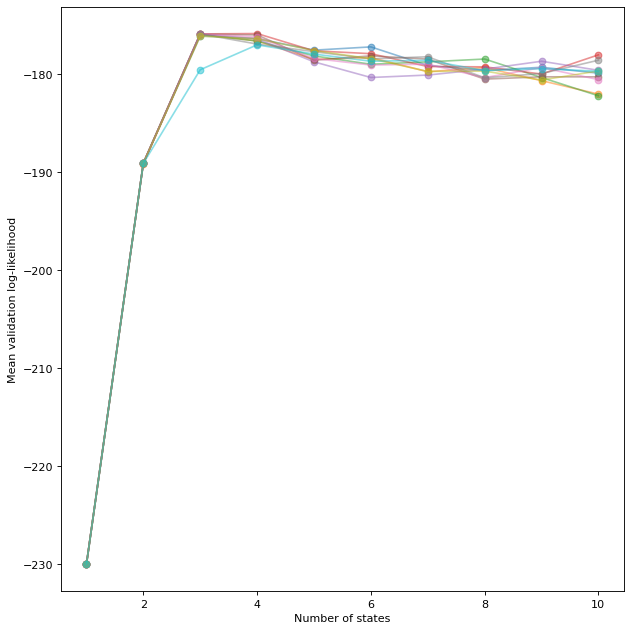

In [ ]:
# plot all cv_scores in cv_scores_concat

fig, ax = plt.subplots(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

for n_iter in range(n_iters):
    ax.plot(list(cv_scores_concat[n_iter].keys()), list(cv_scores_concat[n_iter].values()), 'o-', alpha=0.5)

ax.set_xlabel("Number of states")
ax.set_ylabel("Mean validation log-likelihood")
plt.tight_layout()
plt.show()


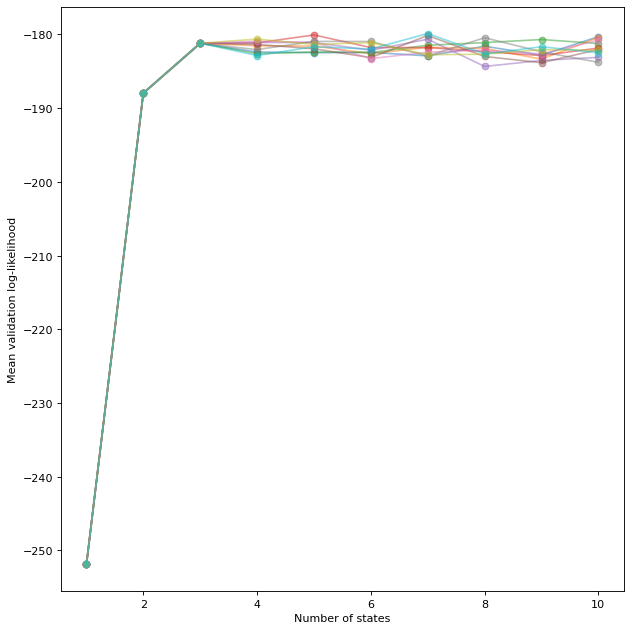

In [ ]:
# plot all cv_scores in cv_scores_concat

fig, ax = plt.subplots(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

for n_iter in range(n_iters):
    ax.plot(list(cv_scores_concat[n_iter].keys()), list(cv_scores_concat[n_iter].values()), 'o-', alpha=0.5)

ax.set_xlabel("Number of states")
ax.set_ylabel("Mean validation log-likelihood")
plt.tight_layout()
plt.show()

In [ ]:
# Define the range of numbers of states to evaluate and other constants
n_states_range = range(1, 11)
n_splits = 5
N_iters = 1000
kf = KFold(n_splits)

# Assuming inpts, true_choices, obs_dim, input_dim, and num_categories are defined elsewhere in your notebook

# Function to evaluate a single state count
def evaluate_state(n_states, inpts, true_choices, obs_dim, input_dim, num_categories):
    val_scores = np.zeros(n_splits)
    for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
        x_train_fold = [inpts[i] for i in train_indices]
        y_train_fold = [true_choices[i] for i in train_indices]
        x_val_fold = [inpts[i] for i in val_indices]
        y_val_fold = [true_choices[i] for i in val_indices]

        new_glmhmm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs",
                             observation_kwargs={"C": num_categories}, transitions="standard")
        new_glmhmm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=1e-4)

        val_scores[i_fold] = new_glmhmm.log_likelihood(y_val_fold, inputs=x_val_fold)

    return n_states, np.mean(val_scores)

# Parallel execution using joblib
cv_scores = Parallel(n_jobs=-1)(delayed(evaluate_state)(n_states, inpts, true_choices, obs_dim, input_dim, num_categories) for n_states in n_states_range)

# Convert list of tuples to dictionary
cv_scores_dict = {n_states: score for n_states, score in cv_scores}

# Print the cross-validation scores
for n_states, score in sorted(cv_scores_dict.items()):
    print(f"n_states = {n_states}, CV score = {score}")

KeyboardInterrupt: 

In [ ]:
# Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Define the range of numbers of states to evaluate
n_states_range = range(1, 3)

# Initialize a KFold object to generate the train/validation indices for each fold
n_splits = 5
N_iters = 200
kf = KFold(n_splits)

# Define a dictionary to store the cross-validation results
cv_scores = {}

# Loop over the number of states to evaluate
for n_states in n_states_range:

    # Initialize a new HMM-GLM with the current number of states
    hmm_glm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
    
    # Initialize an array to store the validation log-likelihoods for the current number of states
    val_scores = np.zeros(n_splits)
    
    # Loop over the folds generated by the KFold object
    for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
        
        # Split the data into training and validation sets for the current fold
        x_train_fold = [inpts[i] for i in train_indices]
        y_train_fold = [true_choices[i] for i in train_indices]
        x_val_fold = [inpts[i] for i in val_indices]
        y_val_fold = [true_choices[i] for i in val_indices]
        
        # Fit the HMM-GLM to the training data for the current fold
        _ = hmm_glm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=10**-4)
        
        # Evaluate the log-likelihood of the validation data for the current fold
        val_scores[i_fold] = hmm_glm.log_likelihood(y_val_fold, inputs=x_val_fold)
    
    # Compute the mean validation score across all folds for the current number of states
    cv_scores[n_states] = np.mean(val_scores)

# Print the cross-validation scores for each number of states
for n_states in n_states_range:
    print(f"n_states = {n_states}, CV score = {cv_scores[n_states]}")

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

n_states = 1, CV score = -503.6854084310322
n_states = 2, CV score = -378.268758565854


In [ ]:
# Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Define the range of numbers of states to evaluate
n_states_range = range(1, 4)

# Initialize a KFold object to generate the train/validation indices for each fold
n_splits = 5
N_iters = 200
kf = KFold(n_splits)

# Define the random seeds to use for initialization
random_seeds = range(10)

# Define a dictionary to store the cross-validation results for each seed
cv_scores_per_seed = {}

# Loop over the random seeds
for seed in random_seeds:
    # Set the random seed for reproducibility
    np.random.seed(seed)
    
    # Define a dictionary to store the cross-validation results for the current seed
    cv_scores = {}
    
    # Loop over the number of states to evaluate
    for n_states in n_states_range:
        # Initialize a new HMM-GLM with the current number of states
        hmm_glm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs", 
                       observation_kwargs=dict(C=num_categories), transitions="standard")
        
        # Initialize an array to store the validation log-likelihoods for the current number of states
        val_scores = np.zeros(n_splits)
        
        # Loop over the folds generated by the KFold object
        for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
            # Split the data into training and validation sets for the current fold
            x_train_fold = [inpts[i] for i in train_indices]
            y_train_fold = [true_choices[i] for i in train_indices]
            x_val_fold = [inpts[i] for i in val_indices]
            y_val_fold = [true_choices[i] for i in val_indices]
            
            # Fit the HMM-GLM to the training data for the current fold
            _ = hmm_glm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=10**-4)
            
            # Evaluate the log-likelihood of the validation data for the current fold
            val_scores[i_fold] = hmm_glm.log_likelihood(y_val_fold, inputs=x_val_fold)
        
        # Compute the mean validation score across all folds for the current number of states
        cv_scores[n_states] = np.mean(val_scores)

    # Store the cross-validation scores for the current seed
    cv_scores_per_seed[seed] = cv_scores

# Print the cross-validation scores for each number of states and each seed
for seed in random_seeds:
    print(f"Seed = {seed}")
    for n_states in n_states_range:
        print(f"  n_states = {n_states}, CV score = {cv_scores_per_seed[seed][n_states]}")

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Seed = 0
  n_states = 1, CV score = -503.68537073537317
  n_states = 2, CV score = -378.2716071212819
  n_states = 3, CV score = -357.905177098204
  n_states = 4, CV score = -357.0380140103692
  n_states = 5, CV score = -355.81153238919944
Seed = 1
  n_states = 1, CV score = -503.68536130013155
  n_states = 2, CV score = -378.24779271863673
  n_states = 3, CV score = -358.38562344937134
  n_states = 4, CV score = -356.56291047788017
  n_states = 5, CV score = -357.23977361051357
Seed = 2
  n_states = 1, CV score = -503.68627999243563
  n_states = 2, CV score = -378.2086054189512
  n_states = 3, CV score = -357.88647432047037
  n_states = 4, CV score = -357.2360363537576
  n_states = 5, CV score = -356.92676165656053
Seed = 3
  n_states = 1, CV score = -503.68536264479025
  n_states = 2, CV score = -378.2259019606696
  n_states = 3, CV score = -357.9054314769845
  n_states = 4, CV score = -356.8577602770536
  n_states = 5, CV score = -354.0694294157063
Seed = 4
  n_states = 1, CV score 

In [10]:
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
import ssm
import os

In [11]:
def evaluate_seed(seed, n_states_range, n_splits, N_iters, inpts, true_choices):
    np.random.seed(seed)
    cv_scores = {}
    kf = KFold(n_splits)
    
    for n_states in n_states_range:
        hmm_glm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs", 
                          observation_kwargs=dict(C=num_categories), transitions="standard")
        val_scores = np.zeros(n_splits)
        
        for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
            x_train_fold = [inpts[i] for i in train_indices]
            y_train_fold = [true_choices[i] for i in train_indices]
            x_val_fold = [inpts[i] for i in val_indices]
            y_val_fold = [true_choices[i] for i in val_indices]
            
            _ = hmm_glm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=10**-4)
            val_scores[i_fold] = hmm_glm.log_likelihood(y_val_fold, inputs=x_val_fold)
        
        cv_scores[n_states] = np.mean(val_scores)
    
    return seed, cv_scores

In [16]:
# Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions
n_states_range = range(1, 4)
n_splits = 5
N_iters = 200
random_seeds = range(10)

available_cores = os.cpu_count()


num_cores = available_cores//4  # Use half of the available cores. Adjust according to your machine's capability.

# Parallel computation
results = Parallel(n_jobs=num_cores)(delayed(evaluate_seed)(seed, n_states_range, n_splits, N_iters, inpts, true_choices) for seed in random_seeds)

# Compile the results
cv_scores_per_seed = {seed: cv_scores for seed, cv_scores in results}

# # Print the cross-validation scores for each number of states and each seed
# for seed in random_seeds:
#     print(f"Seed = {seed}")
#     for n_states in n_states_range:
#         print(f"  n_states = {n_states}, CV score = {cv_scores_per_seed[seed][n_states]}")

Converged to LP: -1472.9:  27%|██▋       | 54/200 [00:00<00:01, 79.29it/s]


In [ ]:
cv_scores_per_seed

{0: {1: -504.0852011552388, 2: -385.8906275373054, 3: -367.530418496315},
 1: {1: -504.08808112537946, 2: -385.8610259282615, 3: -367.4538575570223},
 2: {1: -504.08758799847817, 2: -385.9090210242913, 3: -367.51869106451215},
 3: {1: -504.08518978203574, 2: -385.85390329139796, 3: -367.54686727941964},
 4: {1: -504.08595442530515, 2: -385.8344043069154, 3: -367.52538720005373},
 5: {1: -504.08532387649785, 2: -385.86623272007057, 3: -367.4736496739347},
 6: {1: -504.0851875995786, 2: -385.83210028100376, 3: -367.5080971819074},
 7: {1: -504.0897733913087, 2: -385.8912066586471, 3: -367.4911897759765},
 8: {1: -504.0851866168755, 2: -385.8704147023758, 3: -367.47415905645585},
 9: {1: -504.0880287571623, 2: -385.88168220501456, 3: -367.44053640928445}}

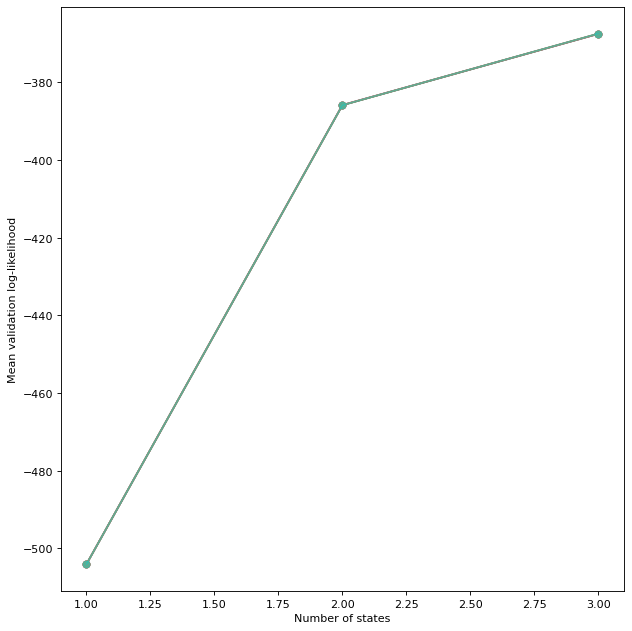

In [ ]:
# plo0t all cv_scores in cv_scores_per_seed for each seed

fig, ax = plt.subplots(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

for seed in random_seeds:
    ax.plot(list(cv_scores_per_seed[seed].keys()), list(cv_scores_per_seed[seed].values()), 'o-', alpha=0.5)

ax.set_xlabel("Number of states")
ax.set_ylabel("Mean validation log-likelihood")
plt.tight_layout()
plt.show()

In [17]:
pwd

'/Users/quentin/Desktop/HeadFixedBehavior/Analysis'